In [1]:
!pip install torch torchvision opencv-python

In [2]:
!pip install imutils torchsummary

In [3]:
import numpy as np
import pandas as pd
import os
from os import listdir
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [5]:
image_dir = "../input/brain-tumor-detection/"

In [6]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import imutils

In [7]:
class CustomDataset(Dataset):
    def __init__(self, directory, transform=None, add_pixels_value=0):
        self.directory = directory
        self.transform = transform
        self.add_pixels_value = add_pixels_value
        self.image_paths = [os.path.join(directory, img_name) for img_name in os.listdir(directory)]
        self.labels = [self.get_label(os.path.join(directory, img_name)) for img_name in os.listdir(directory)]

    def get_label(self, img_name):
        label = 1 if 'yes' in img_name else 0
        return label

    def crop_image(self, img):
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # Add contour on the image
        img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

        # Add extreme points
        img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
        img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
        img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
        img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

        ADD_PIXELS = self.add_pixels_value

        ADD_PIXELS = self.add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        return new_img

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = self.crop_image(image)
        image = cv2.resize(image, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [8]:
IMG_SIZE  = (224, 224)

In [9]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=(0.1, 1.5)),
    transforms.RandomAffine(degrees=0, shear=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
# train_data = []
# for root, dirs, files in os.walk(image_dir+"/Training"):
#     for dir_name in dirs:
#         train_data += CustomDataset(directory=os.path.join(root, dir_name), transform=test_transform)
        
# print(f"Number of images in 'training' dataset: {len(train_data)}")

Number of images in 'training' dataset: 0


In [11]:
# test_data = []
# for root, dirs, files in os.walk(image_dir+"/Testing"):
#     for dir_name in dirs:
#         test_data += CustomDataset(directory=os.path.join(root, dir_name), transform=test_transform)
        
# print(f"Number of images in 'Testing' dataset: {len(test_data)}")

Number of images in 'Testing' dataset: 0


In [12]:
# Load datasets
yes_dataset = CustomDataset(directory=image_dir+'/yes', transform=test_transform)
no_dataset = CustomDataset(directory=image_dir+'/no', transform=test_transform)

In [13]:
# Combine and split the datasets
dataset = yes_dataset + no_dataset
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# train_data, _ = train_test_split(train_data, test_size=0.95, random_state=42)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [14]:
print(f"Number of images in Training: {len(train_data)}")
print(f"Number of images in Testing: {len(test_data)}")

Number of images in Training: 2400
Number of images in Testing: 600


In [15]:
import math

to_pil = transforms.ToPILImage()

def plot_samples(data_loader, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    # Determine the number of rows and columns for the grid
    cols = int(math.ceil(n ** 0.5))
    rows = int(math.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    axes = axes.flatten()
    
    for i, (img, label) in enumerate(data_loader):
        if i >= n:
            break
        pil_img = to_pil(img)  # Convert tensor to PIL image
        axes[i].imshow(pil_img)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [16]:
# plot_samples(train_data, 30)

In [17]:
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.dropout1 = nn.Dropout(0.5)  
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  
        x = self.fc2(x)
        return x

In [18]:
# class BrainTumorCNN(nn.Module):
#     def __init__(self):
#         super(BrainTumorCNN, self).__init__()
#         self.model = models.resnet18(pretrained=True)
#         self.model.fc = nn.Linear(self.model.fc.in_features, 1)

#     def forward(self, x):
#         x = self.model(x)
#         return x


In [19]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorCNN().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [20]:
# Print the model summary
summary(model, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Linear-7                  [-1, 512]     102,760,960
           Dropout-8                  [-1, 512]               0
            Linear-9                    [-1, 1]             513
Total params: 102,781,057
Trainable params: 102,781,057
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 41.35
Params size (MB): 392.08
Estimated Total Size (MB): 434.00
------------------------------

In [21]:
# Training Loop
def train(model, train_loader, criterion, optimizer, num_epochs=35):
    best_accuracy = 0
   
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        t_correct = 0
        t_total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1).float() 
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            predicted = torch.sigmoid(outputs) >= 0.5
#             _, predicted = torch.max(outputs.data, 1)
            t_total += labels.size(0)
            t_correct += (predicted == labels).sum().item()
                
        epoch_training_accuracy = (100 * t_correct / t_total)
#         print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Training Accuracy: {epoch_training_accuracy:.2f}%')
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device).unsqueeze(1).float()  
                outputs = model(images)
                predicted = torch.sigmoid(outputs) >= 0.5
#                 _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        epoch_accuracy = (100 * correct / total)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Training Accuracy: {epoch_training_accuracy:.2f}%,Testing Accuracy: {epoch_accuracy:.2f}%')
        
#         print(f'Accuracy: {epoch_accuracy:.2f}%')
        
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            torch.save({'epoch': epoch + 1, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),'loss': criterion}, './best_weight_cnn.pth')

In [22]:
# Train the model
train(model, train_loader, criterion, optimizer,50)

Epoch 1/50, Loss: 1.197609966993332, Training Accuracy: 75.79%,Testing Accuracy: 89.67%
Epoch 2/50, Loss: 0.28801173001527786, Training Accuracy: 87.54%,Testing Accuracy: 93.17%
Epoch 3/50, Loss: 0.16372750689586005, Training Accuracy: 93.38%,Testing Accuracy: 93.50%
Epoch 4/50, Loss: 0.1299500813583533, Training Accuracy: 95.29%,Testing Accuracy: 96.50%
Epoch 5/50, Loss: 0.08127607131997744, Training Accuracy: 97.29%,Testing Accuracy: 97.67%
Epoch 6/50, Loss: 0.05883791825423638, Training Accuracy: 98.38%,Testing Accuracy: 96.67%
Epoch 7/50, Loss: 0.03506838206822673, Training Accuracy: 99.17%,Testing Accuracy: 97.33%
Epoch 8/50, Loss: 0.03477080502857765, Training Accuracy: 99.12%,Testing Accuracy: 97.83%
Epoch 9/50, Loss: 0.025460479374354084, Training Accuracy: 99.38%,Testing Accuracy: 98.00%
Epoch 10/50, Loss: 0.013187828799709677, Training Accuracy: 99.83%,Testing Accuracy: 97.83%
Epoch 11/50, Loss: 0.010722082608068983, Training Accuracy: 99.92%,Testing Accuracy: 97.67%
Epoch 12

In [23]:
model_best = BrainTumorCNN().to(device)

best_model_cp = torch.load('best_weight_cnn.pth')
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")

Best model was saved at 34 epochs



In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Evaluation

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    tp,tn,fp,fn = 0,0,0,0
    total_confusion_matrix = None
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1).float() 
            outputs = model(images)
            predicted = torch.sigmoid(outputs) >= 0.5
#             _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_confusion_matrix = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=[0, 1])
#             batch_confusion_matrix = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())
            if total_confusion_matrix is None:
                total_confusion_matrix = batch_confusion_matrix
            else:
                total_confusion_matrix += batch_confusion_matrix
            etn, efp, efn, etp = batch_confusion_matrix.ravel()

            tp += etp
            tn += etn
            fp += efp
            fn += efn
    
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print(f'Accuracy: {(100 * correct / total):.2f}%, Total: {total}, Correct: {correct}, Wrong: {total-correct}')
    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(total_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

TP: 308, TN: 284, FP: 3, FN: 5
Accuracy: 98.67%, Total: 600, Correct: 592, Wrong: 8


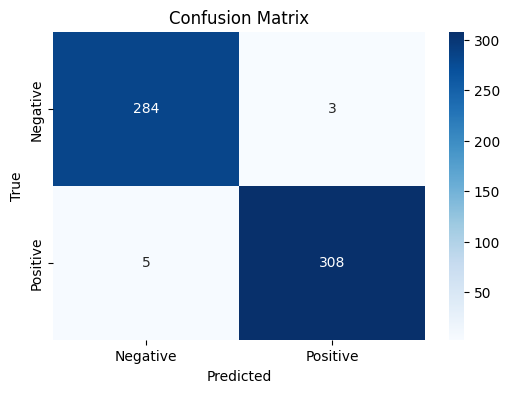

In [26]:
# Evaluate the model
model_best.load_state_dict(best_model_cp['model_state_dict'])

evaluate(model_best, test_loader)